In [6]:
# TODO
# change dv/dt to be cumulative using np.cumsum; see changes in func S09SF18varoutlines_dhdvdt_anim
# make dh/dt planview 1x2 aggregated variable outlines that compares CS2 and IS2 variable outlines over the IS2 era
# 2x2 dh/dt and variable outline plot of late CS2 era compared to IS2 era; lefthand is quarterly dh/dt with variable outlines; righthand side is aggregated variable outlines?
# create and heavily comment introductory cell on the general outline delineation procedure
# modify S09SF18varoutlines_agg_plot to also create animation building agg plot with agg plot as last frame; save animation
# modify S09SF18varoutlines_dhdt_plot_anim for last frame to be agg plot of variable outlines 
# have animations end on last frame (mp4 vs gif)
# find faster thresholding method to use CS2 count to look at data based on a threshold of data points
# make legend dynamic where it will include S09 citation if there is a S09 lake within the bounding box; same with SF18
# have dh/dt and dv/dt 2D line plots label the threshold level selected
# plots for combined Mac 4+5 and Slessor 4+5 since so close and hard to disentangle
# move 'dates = []' from out of for loops to so they are not reset each time
# modify S09SF18varoutlines_agg_plot to plot using S09 lake name; examine Recovery_8
# make functions intake a list of S09 and a list of SF18 lakes to be included in plot
# make dvdt plots have symbols for actual data points and dotted lines between
# convert polys[i].area to calc geodesic area instead
# when making contours, perhaps clip to buffer area around lake once you know rough bounds of where off-lake extensions will be so you can clip out other nearby actvity?
# add gl to plots
# change S09SF18varoutlines_dhdvdt_anim to add buffer to ylimits that is alternative to *1.1, which doesn't work for zero

In [7]:
# Code to delineate subglacial lakes using variable outlines based on 
# ice surface height deformation contours, visualize and quantify lake 
# average dh/dt and lake dv/dt. 
#
# Written 2022-06-06 by W. Sauthoff (sauthoff@mines.edu)

# import packages
import rioxarray
import geopandas as gpd
from matplotlib import animation
import matplotlib.pyplot as plt
import cmocean
from skimage import measure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
from datetime import datetime as dt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.path as mpath
from matplotlib.patches import Ellipse, Rectangle
import math
import time

def toYearFraction(date): # https://stackoverflow.com/a/6451892/5972778
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [8]:
# define data and script directory (replace with your data directory file path) and file path
data_dir = '/Volumes/Extreme SSD/data'
script_dir = '/Users/Wilson/Documents/0-code/scripts'

In [9]:
# import CryoSat-2 data (closed-source data acquired from Ben Smith)
outlines = open(script_dir + '/Smith_CS2.py')
read_file = outlines.read()
exec(read_file)

# view data set
CS2_dh

<xarray.Dataset>
Dimensions:  (y: 4451, x: 5451, time: 45)
Coordinates:
  * y        (y) float64 2.265e+06 2.264e+06 2.263e+06 ... -2.184e+06 -2.185e+06
  * x        (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time     (time) float64 2.01e+03 2.011e+03 2.011e+03 ... 2.021e+03 2.022e+03
Data variables:
    mask     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    delta_h  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    count    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    fileName:  mos_2010.5_2021.5.h5

In [10]:
# import CryoSat-2 data (closed-source data acquired from Ben Smith)
outlines = open(script_dir + '/Smith_CS2.py')
read_file = outlines.read()
exec(read_file)

# view data set
CS2_dh

<xarray.Dataset>
Dimensions:  (y: 4451, x: 5451, time: 45)
Coordinates:
  * y        (y) float64 2.265e+06 2.264e+06 2.263e+06 ... -2.184e+06 -2.185e+06
  * x        (x) float64 -2.665e+06 -2.664e+06 ... 2.784e+06 2.785e+06
  * time     (time) float64 2.01e+03 2.011e+03 2.011e+03 ... 2.021e+03 2.022e+03
Data variables:
    mask     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    delta_h  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    count    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    fileName:  mos_2010.5_2021.5.h5

In [11]:
# import ICESat-2 ATL15 Gridded Antarctic Land Ice Height data product 
# https://doi.org/10.5067/ATLAS/ATL15.001
file = data_dir + '/altimetry/ICESat-2/ATL15.001-Ant/ATL15_AA_0311_01km_001_01.nc'
ATL15_dh = rioxarray.open_rasterio(file, group='delta_h', masked=True)
# display xarray data set meta data
ATL15_dh

<xarray.Dataset>
Dimensions:              (y: 4521, x: 5521, band: 1, time: 12)
Coordinates:
  * y                    (y) float64 2.32e+06 2.319e+06 ... -2.199e+06 -2.2e+06
  * x                    (x) float64 -2.72e+06 -2.719e+06 ... 2.799e+06 2.8e+06
  * band                 (band) int64 1
    Polar_Stereographic  int64 0
  * time                 (time) float64 273.9 365.2 ... 1.187e+03 1.278e+03
Data variables:
    cell_area            (band, y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    ice_mask             (band, y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes: (12/118)
    description:                        This data set (ATL15) contains season...
    identifier:                         atl15_qa_util
    pulse_rate:                         10000 pps
    type:                               Spacecraft
    wavelength:                         532 nm
    Description:                        Describe the group
    ...                                 ...
    summary:                            The purpose of ATL15 is to provide an...
    time_coverage_duration:             70616089.15128851
    time_coverage_end:                  2021-06-23T16:19:43.177120Z
    time_coverage_start:                2019-03-29T08:44:54.025831Z
    time_type:                          CCSDS UTC-A
    vertical_datum:                     WGS84

In [12]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
gl = data_dir + '/boundaries/Depoorter2013-boundaries/scripps_antarctica_polygons_v1.shp' 
Scripps_gl = gpd.read_file(gl)

In [13]:
# import subglacial lake outlines 
outlines = open(script_dir + '/Smith2009_outlines.py')
read_file = outlines.read()
exec(read_file)

outlines = open(script_dir + '/SiegfriedFricker2018_outlines.py')
read_file = outlines.read()
exec(read_file)

# drop outlines from SiegfiedFricker2018_outlines that are duplicative of Smith2009_outlines
SiegfriedFricker2018_newoutlines = SiegfriedFricker2018_outlines.copy(deep=True)
SiegfriedFricker2018_newoutlines.drop(SiegfriedFricker2018_newoutlines.loc[SiegfriedFricker2018_newoutlines['cite'].str.contains('Smith and others, 2009')].index, inplace=True)

# Introduction to time-variable outline delineation method


# Func S09SF18varoutlines_agg_plot

In [24]:
def S09SF18varoutlines_agg_plot(lakename_SF18, buffer, thres, dataset): 
    '''
    Create planview plot of an aggregated times series of variable outlines compared to known lakes. Uses geopandas buffer created bounding box 
    around known lakes in Siegfried and Fricker, 2018 (SF18) inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Aggregated time-variable lake outlines in regions of known lakes using CryoSat-2 or ICESat-2 ATL15 dh/dt data.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_SF18]
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # only plot lakes with signal above arbitrary background noise
    if max_height_anom_abs >= 1: 
        # create contours of ice surface elevation height changes to delineate lake outlines
        dates = []
        # plot figure
        fig, ax = plt.subplots(figsize=(10,10))
        cmap = plt.get_cmap('CMRmap')
        norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
        for idx in range(len(ds_sub.time)-1): 
            # subset data to dhdt diff between orbital cycles of delta_h
            dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            # calculate mid-cycle dates for plotting
            if dataset.fileName == 'mos_2010.5_2021.5.h5':
                newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
                newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays
                dates += [midcycdate]
            elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
                date_time_str = '18-01-01'
                date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
                newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
                newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays/2
                dates += [midcycdate]
            # create contours of ice surface elevation height changes to delineate variable lake outlines       
            contours_fill = []
            contours_drain = []
            contour = measure.find_contours(dhdt.values, thres)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres)
            if len(contour) > 0: 
                contours_drain += [contour]
            # create mapping conversion factor to map array location to polar stereographic x,y
            x_conv = (x_max-x_min)/dhdt.shape[1]
            y_conv = (y_max-y_min)/dhdt.shape[0]
            # plot variable outlines found in this time slice
            for i in range(len(contours_fill)): 
                for j in range(len(contours_fill[i])):
                    ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                    color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1) 
            for i in range(len(contours_drain)): 
                for j in range(len(contours_drain[i])):
                    ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, 
                    color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        ax.set_xlabel('polar stereographic x [m]', size=15)
        ax.set_ylabel('polar stereographic y [m]', size=15)
        ax.ticklabel_format(axis='both',scilimits=(0,0))
        ax.set_title(lakename_SF18+ '\noutline comparison', pad=7.5, fontsize=17.5)
        m = plt.cm.ScalarMappable(cmap=cmap)
        m.set_array(np.array([toYearFraction(date) for date in dates[0:-1]]))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.2)
        fig.colorbar(m, cax=cax).set_label('Year', size=15) # arg for whole number years later: format="%d", must find way to control no. ticks
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 5)), linewidth=1)
        SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle=(0, (1, 1)), linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
        ax.legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
            ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
            ('+ '+str(thres)+' m uplift (filling) variable outline'), '- '+str(thres)+' m subsidence (draining) variable outline'], 
            loc='best')
        # plot inset map to show location 
        axIns = ax.inset_axes([0.05, 0.001, 0.25, 0.25])
        axIns.patch.set_facecolor('lightskyblue')
        axIns.set_aspect('equal')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
            linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
        Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
        axIns.axis('off')
        # save and close figure
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_agg_plot/S09SF18varoutlines_agg-{}-{}.png'.format(lakename_SF18,'CS2'), dpi=300, bbox_inches = "tight")
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_agg_plot/S09SF18varoutlines_agg-{}-{}.png'.format(lakename_SF18,'IS2'), dpi=300, bbox_inches = "tight")
        plt.close()
    else: print('absolute max height anomaly is less than plotting threshold')

In [25]:
# test function working using one lake
# S09SF18varoutlines_agg_plot('Whillans_7', 10000, 0.75, CS2_dh)
S09SF18varoutlines_agg_plot('Whillans_7', 10000, 0.75, ATL15_dh)

In [ ]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename=SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_agg_plot(lakename, 7500, 0.75, CS2_dh)
    S09SF18varoutlines_agg_plot(lakename, 7500, 0.75, ATL15_dh)

In [68]:
# redo a few plots that need larger buffer
# S09SF18varoutlines_agg_plot('UpperSubglacialLakeConway', 8500, 0.75, CS2_dh)

# S09SF18varoutlines_agg_plot('MercerSubglacialLake', 5500, 0.75, CS2_dh)
# S09SF18varoutlines_agg_plot('MercerSubglacialLake', 5500, 0.75, ATL15_dh)

# S09SF18varoutlines_agg_plot('Slessor_23', 8500, 0.75, CS2_dh)
S09SF18varoutlines_agg_plot('Slessor_23', 8500, 0.75, ATL15_dh)

# S09SF18varoutlines_agg_plot('Lambert_1', 9000, 0.75, CS2_dh)
# S09SF18varoutlines_agg_plot('Lambert_1', 9000, 0.75, ATL15_dh)

# S09SF18varoutlines_agg_plot('Whillans_7', 9000, 0.75, ATL15_dh)


In [25]:
def S09SF18varoutlines_dhdt_plot_anim(lakename_SF18, buffer, thres, dataset): 
    '''
    Create planview dh/dt plots of ice surface height changes using geopandas buffer created bounding box around known lakes in 
    Siegfried and Fricker, 2018 (SF18) inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Sequence of planview dh/dt visuals of CryoSat-2 or ICESat-2 ATL15 with variable ice surface deformation contours plotted to delineate time-variable lake boundary.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # only plot lakes with signal above arbitrary background noise
    if max_height_anom_abs >= 1: 
        # create fig, ax, colorbar
        fig, ax = plt.subplots(figsize=(8,8))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.2)
        # create empty list to store animation im(age)s
        ani = animation.PillowWriter(fps=2)
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdt_plot_anim/anim/S09SF18varoutlines_dhdt_anim-{}-dhdt-{}.gif'.format(lakename_SF18, 'CS2'), dpi=300)
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdt_plot_anim/anim/S09SF18varoutlines_dhdt_anim-{}-dhdt-{}.gif'.format(lakename_SF18, 'IS2'), dpi=300)
        dates = []
        for idx in range(len(ds_sub.time)-1): 
            dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            # calculate mid-cycle dates for plotting
            if dataset.fileName == 'mos_2010.5_2021.5.h5':
                newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
                newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays/2
                dates += [midcycdate]
            elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
                date_time_str = '18-01-01'
                date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
                newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
                newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays/2
                dates += [midcycdate]
            # plot figure
            dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            img = ax.imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
                origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
            # create contours of ice surface elevation height changes to delineate lake outlines
            contours_fill = []
            contours_drain = []
            contour = measure.find_contours(dhdt.values, thres)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres)
            if len(contour) > 0: 
                contours_drain += [contour]
            # create mapping conversion factor to map array location to polar stereographic x,y
            x_conv = (x_max-x_min)/dhdt.shape[1]
            y_conv = (y_max-y_min)/dhdt.shape[0]
            # plot variable outlines found in this time slice
            for i in range(len(contours_fill)): 
                for j in range(len(contours_fill[i])):
                    ax.plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
            for i in range(len(contours_drain)): 
                for j in range(len(contours_drain[i])):
                    ax.plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
            ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
            ax.set_xlabel('polar stereographic x [m]', size=15)
            ax.set_ylabel('polar stereographic y [m]', size=15)
            ax.ticklabel_format(axis='both',scilimits=(0,0))
            ax.set_title(lakename_SF18+' dh/dt + outline comparison \n$h_{'+newdate1.strftime('%m/%Y')+'} - h_{'+newdate.strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
            fig.colorbar(img, cax=cax).set_label('Height (h) change [m]', size=15)
            # overlay published outlines for visual comparison 
            Smith2009_outlines.boundary.plot(ax=ax, color='k', linestyle='--', linewidth=1)
            SiegfriedFricker2018_outlines.boundary.plot(ax=ax, color='k', linestyle='-', linewidth=1)
            Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
            SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
            uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
            subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
            ax.legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
                ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
                ('+ '+str(thres)+' m uplift (filling) variable outline'), '- '+str(thres)+' m subsidence (draining) variable outline'], 
                loc='best')
            # plot inset map to show location 
            axIns = ax.inset_axes([0.05, 0.001, 0.25, 0.25])
            axIns.patch.set_facecolor('lightskyblue')
            axIns.set_aspect('equal')
            axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
                linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
            Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
            axIns.axis('off')
            # save and close figure
            if dataset.fileName == 'mos_2010.5_2021.5.h5':
                plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdt_plot_anim/plot/S09SF18varoutlines_dhdt_plot-{}-{}-dhdt-{}.png'.format(lakename_SF18,'CS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")
            elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
                plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdt_plot_anim/plot/S09SF18varoutlines_dhdt_plot-{}-{}-dhdt-{}.png'.format(lakename_SF18,'IS2',midcycdate.strftime('%Y-%m')), dpi=300, bbox_inches = "tight")      
            # append im(age) to ims list
            ani.grab_frame()
            ax.clear()
        # finish animation
        ani.finish()
        plt.close()
    else: print('absolute max height anomaly is less than plotting threshold')

In [26]:
# test function working using one lake
# S09SF18varoutlines_dhdt_plot_anim('Whillans_7', 10000, 0.75, CS2_dh)
S09SF18varoutlines_dhdt_plot_anim('Whillans_7', 10000, 0.75, ATL15_dh)

In [ ]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename=SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_dhdt_plot_anim(lakename, 7500, 0.75, CS2_dh)
    S09SF18varoutlines_dhdt_plot_anim(lakename, 7500, 0.75, ATL15_dh)

In [48]:
def S09SF18varoutlines_agg_dvdt_plot(lakename_SF18, buffer, thres, dataset): 
    '''
    Create planview plot of an aggregated times series of variable outlines compared to known lakes alongside dv/dt time series. Uses geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 (SF18) inventory. Creates time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Inputs: 
        lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters away from SF18 lake outline used to create bounding box that is displayed around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Aggregated time-variable lake outlines in regions of known lakes using CryoSat-2 or ICESat-2 ATL15 dh/dt data alongside dv/dt time series.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_SF18]
    lake_gpd = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_gpd.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # only plot lakes with signal above arbitrary background noise
    if max_height_anom_abs >= 1: 
        dates = []
        lkavgdhdt_SF18 = []
        lkavgdhdt_var = []
        vols_SF18 = []
        vols_var = []
        # plot figure
        fig, axes = plt.subplots(1,2, figsize=(20,10))
        plt.subplots_adjust(wspace=0.15)
        cmap = plt.get_cmap('CMRmap')
        norm = plt.Normalize(ds_sub.time.values[0],ds_sub.time.values[-1])    
        for idx in range(len(ds_sub.time)-1): 
            dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            # calculate mid-cycle dates for plotting
            if dataset.fileName == 'mos_2010.5_2021.5.h5':
                newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
                newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays
                dates += [midcycdate]
            elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
                date_time_str = '18-01-01'
                date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
                newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
                newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays/2
                dates += [midcycdate]
            # subset data to dhdt diff between orbital cycles of delta_h
            dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            # clip ATL15 data to just show (first set crs)
            dhdt.rio.write_crs(3031, inplace=True)
            dhdt_clip_SF18 = dhdt.rio.clip(lake_gpd.geometry.values, lake_gpd.crs, drop=False, invert=False)
            # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
            avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
            lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
            vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_SF18]['area (m^2)']
            vols_SF18 += [vol_SF18.values[0]]
            # create contours of ice surface elevation height changes to delineate variable lake outlines
            contours_fill = []
            contours_drain = []   
            polys = []
            contour = measure.find_contours(dhdt.values, thres)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres)
            if len(contour) > 0: 
                contours_drain += [contour]
            # create mapping conversion factor to map array location to polar stereographic x,y
            x_conv = (x_max-x_min)/dhdt.shape[1]
            y_conv = (y_max-y_min)/dhdt.shape[0]
            # plot variable outlines found in this time slice
            # make polygons from variable outlines
            for i in range(len(contours_fill)): 
                for j in range(len(contours_fill[i])):
                    axes[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, 
                    color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                    if len(contours_fill[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                        polys += [poly]
            for i in range(len(contours_drain)): 
                for j in range(len(contours_drain[i])):
                    axes[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color=cmap(norm(ds_sub.time.values[idx])), linestyle=(0, (5, 1)), linewidth=1)
                    if len(contours_drain[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                        polys += [poly]
            # set area to zero each time step
            variable_area = 0
            # if polygons are present at time step, 
            if len(polys) > 0: 
                # clip data to polygons
                dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
                # then calculate on-lake averages of dh/dt
                avg_lk_dhdt = np.nanmean(dhdt_clip)
                # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
                # replace with zeros
                if math.isnan(avg_lk_dhdt): 
                    avg_lk_dhdt = 0
                    lkavgdhdt_var += [avg_lk_dhdt]
                else:
                    lkavgdhdt_var += [avg_lk_dhdt]
                    # and dv/dt
                for i in range(len(polys)):
                    variable_area = variable_area + polys[i].area
                vol_var = avg_lk_dhdt*variable_area
                vols_var += [vol_var]
            else: 
                variable_area = 0
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
                vol_var = avg_lk_dhdt*variable_area
                vols_var += [vol_var]
        axes[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        axes[0].set_xlabel('polar stereographic x [m]', size=15)
        axes[0].set_ylabel('polar stereographic y [m]', size=15)
        axes[0].ticklabel_format(axis='both',scilimits=(0,0))
        axes[0].set_title(lakename_SF18+ ' outline comparison', pad=7.5, fontsize=17.5)
        m = plt.cm.ScalarMappable(cmap=cmap)
        m.set_array(np.array([toYearFraction(date) for date in dates[0:-1]]))
        divider = make_axes_locatable(axes[0])
        cax = divider.append_axes('right', size='5%', pad=0.2)
        clb = fig.colorbar(m, cax=cax)
        clb.ax.set_title('Year')
        # overlay published outlines for visual comparison 
        Smith2009_outlines.boundary.plot(ax=axes[0], color='k', linestyle=(0, (1, 5)), linewidth=1)
        SiegfriedFricker2018_outlines.boundary.plot(ax=axes[0], color='k', linestyle=(0, (1, 1)), linewidth=1)
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 5)), linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (1, 1)), linewidth=2)
        uplift = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
        subsidence = plt.Line2D((0, 1), (0, 0), color='k', linestyle=(0, (5, 1)), linewidth=1)
        variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        axes[0].legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
            ['Smith and others, 2009 outline','Siegfried & Fricker, 2018 outline',
            ('+ '+str(thres)+' m uplift (filling) variable outline'), '- '+str(thres)+' m subsidence (draining) variable outline'], 
            loc='upper right')
        # plot inset map to show location 
        axIns = axes[0].inset_axes([0.05, 0.001, 0.25, 0.25])
        axIns.patch.set_facecolor('lightskyblue')
        axIns.set_aspect('equal')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
            linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
        Scripps_gl.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.5, zorder=2)
        axIns.axis('off')
        # plot dvdt subplot
        axes[1].plot(dates, np.divide(np.cumsum(vols_SF18), 1e+9), color='k', linestyle='dashed')
        axes[1].plot(dates, np.divide(np.cumsum(vols_var), 1e+9), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        axes[1].xaxis.set_major_locator(locator)
        axes[1].xaxis.set_major_formatter(formatter)
        axes[1].set_title('{} dv/dt'.format(lakename_SF18), fontsize=17.5)
        axes[1].set_xlabel('Year', size=15)
        axes[1].set_ylabel('Volume change [km$^3$]', size=15)
        axes[1].yaxis.tick_right()
        axes[1].yaxis.set_label_position("right")
        axes[1].legend([SiegfriedFricker2018,variable_outlines],
            ['Siegfried & Fricker, 2018',
            '±{} m variable outlines'.format(thres)], 
            loc='best')  
        # save and close figure
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_agg_dvdt_plot/S09SF18varoutlines_agg_dvdt_plot-{}-{}.png'\
                .format(lakename_SF18, 'CS2'), dpi=300, bbox_inches = "tight")
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_agg_dvdt_plot/S09SF18varoutlines_agg_dvdt_plot-{}-{}.png'\
                .format(lakename_SF18, 'IS2'), dpi=300, bbox_inches = "tight")
    else: print('absolute max height anomaly is less than plotting threshold')

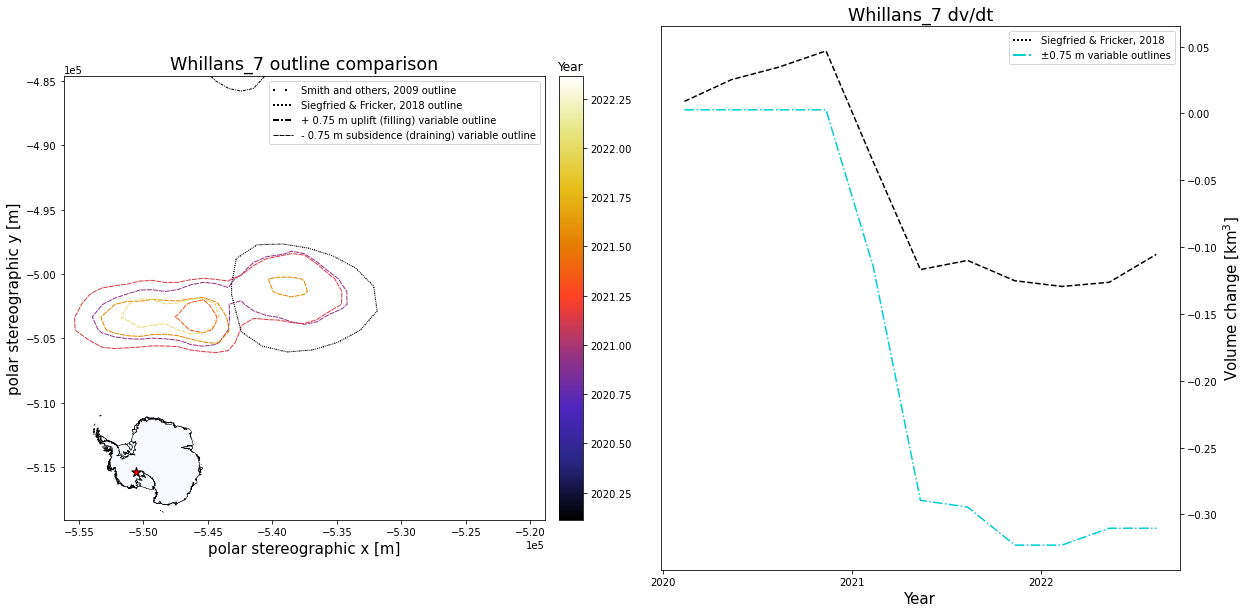

In [49]:
# test function working using one lake
# S09SF18varoutlines_agg_dvdt_plot('Whillans_7', 10000, 0.75, CS2_dh)
S09SF18varoutlines_agg_dvdt_plot('Whillans_7', 13000, 0.75, ATL15_dh)

In [ ]:
# run func on all lakes from SF18 inventory
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename=SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_agg_dvdt_plot(lakename, 7500, 0.75, CS2_dh)
    S09SF18varoutlines_agg_dvdt_plot(lakename, 7500, 0.75, ATL15_dh)

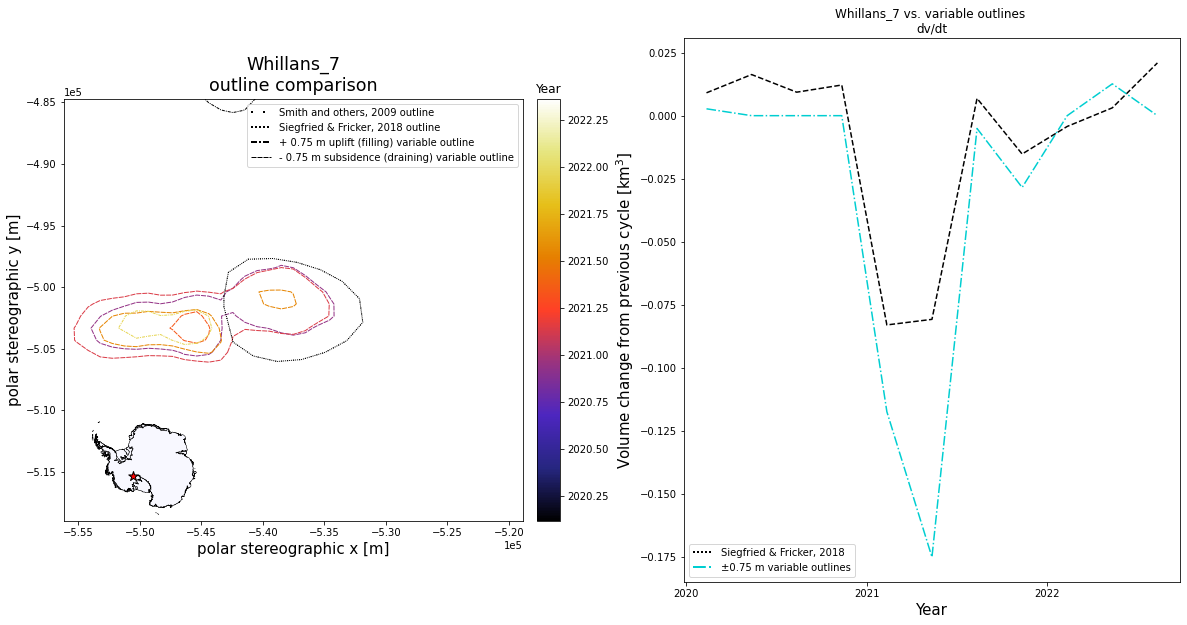

In [122]:
# redo a few plots that need larger buffer
S09SF18varoutlines_agg_dvdt_plot('Whillans_7', 13000, 0.75, ATL15_dh)

In [50]:
def S09SF18varoutlines_dhdvdt_anim(lakename_SF18, buffer, thres, dataset): 
    '''
    Create dh/dt plots ice surface height changes using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Use time-variable outlines to calculate dv/dt.
    Save images together into GIF animation.
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
        dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
    Outputs: 
        Animations of planview dh/dt visuals with variable ice surface deformation contours plotted to delineate time-variable lake boundary 
        alongside 2-D line plots of cumulative dv/dt using static and variable outlines that updates simultaneously to planview dh/dt animation.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # only plot lakes with signal above arbitrary background noise
    if max_height_anom_abs >= 1: 
        # create empty lists to store calculated data
        dates = []
        polys = []
        lkavgdhdt_SF18 = []
        lkavgdhdt_var = []
        vols_SF18 = []
        vols_var = []
        for idx in range(len(ds_sub.delta_h)-1): 
            dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            # calculate mid-cycle dates for plotting
            if dataset.fileName == 'mos_2010.5_2021.5.h5':
                newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
                newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays
                dates += [midcycdate]
            elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
                date_time_str = '18-01-01'
                date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
                newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
                newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays
                dates += [midcycdate]
            # clip ATL15 data to just show (first set crs)
            dhdt.rio.write_crs(3031, inplace=True)
            dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
            # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
            avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
            lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
            vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_SF18]['area (m^2)']
            vols_SF18 += [vol_SF18.values[0]]
            # create contours of ice surface elevation height changes to delineate lake outlines
            contours_fill = []
            contours_drain = []
            contour = measure.find_contours(dhdt.values, thres)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres)
            if len(contour) > 0: 
                contours_drain += [contour]
            # create mapping conversion factor to map array location to polar stereographic x,y
            x_conv = (x_max-x_min)/dhdt.shape[1]
            y_conv = (y_max-y_min)/dhdt.shape[0]
            # make polygons from variable outlines
            for i in range(len(contours_fill)): 
                for j in range(len(contours_fill[i])):
                    if len(contours_fill[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                        polys += [poly]
            for i in range(len(contours_drain)): 
                for j in range(len(contours_drain[i])):
                    if len(contours_drain[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                        polys += [poly]
            # start with baseline variable outline area of zero
            variable_area = 0
            # if polygons are present at time step, 
            if len(polys) > 0: 
                # clip data to polygons (first set crs)
                # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
                dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
                # then calculate on-lake averages of dh/dt
                avg_lk_dhdt = np.nanmean(dhdt_clip)
                # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
                # replace with zeros
                if math.isnan(avg_lk_dhdt): 
                    avg_lk_dhdt = 0
                    lkavgdhdt_var += [avg_lk_dhdt]
                else:
                    lkavgdhdt_var += [avg_lk_dhdt]
                # and dv/dt
                for i in range(len(polys)):
                    variable_area = variable_area + polys[i].area # CHANGE TO GEODESIC AREA
                vol_var = avg_lk_dhdt*variable_area
                vols_var += [vol_var]
            else: 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
                vol_var = avg_lk_dhdt*variable_area
                vols_var += [vol_var]
        # create colorbar axis
        fig, axes = plt.subplots(1,2, figsize=(20,10))
        divider = make_axes_locatable(axes[0])
        cax = divider.append_axes('right', size='5%', pad=0.2)
        # create empty list to store animation im(age)s
        ani = animation.PillowWriter(fps=1)
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdvdt_anim/S09SF18varoutlines_dhdvdt_anim-{}-{}.gif'.format(lakename_SF18, 'CS2'), dpi=300)
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdvdt_anim/S09SF18varoutlines_dhdvdt_anim-{}-{}.gif'.format(lakename_SF18, 'IS2'), dpi=300)
        for idx in range(len(ds_sub.delta_h)-1): 
            dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            img = axes[0].imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
                origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
            # create contours of ice surface elevation height changes to delineate lake outlines
            contours_fill = []
            contours_drain = []
            contour = measure.find_contours(dhdt.values, thres)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres)
            if len(contour) > 0: 
                contours_drain += [contour]
            # subplot 1: plot variable outlines found in this time slice
            for i in range(len(contours_fill)): 
                for j in range(len(contours_fill[i])):
                    axes[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
            for i in range(len(contours_drain)): 
                for j in range(len(contours_drain[i])):
                    axes[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
            axes[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
            axes[0].set_xlabel('polar stereographic x [m]', size=15)
            axes[0].set_ylabel('polar stereographic y [m]', size=15)
            axes[0].ticklabel_format(axis='both',scilimits=(0,0))
            axes[0].set_title(lakename_SF18+' dh/dt \n$h_{'+dates[idx].strftime('%m/%Y')+'} - h_{'+dates[idx-1].strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
            fig.colorbar(img, cax=cax).set_label('Height (h) change [m]', size=15)
            # overlay published outlines for visual comparison 
            Smith2009_outlines.boundary.plot(ax=axes[0], color='k', linestyle='--', linewidth=1)
            SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879']\
                .boundary.plot(ax=axes[0], color='k', linestyle='-', linewidth=1)
            Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
            SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
            uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
            subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
            axes[0].legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
                ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
                ('+ '+str(thres)+' m uplift (filling) variable outline'), '- '+str(thres)+' m subsidence (draining) variable outline'], 
                loc='upper left')
            # suplot 2: plot volume change time series
            axes[1].plot(dates[:idx+1], np.divide(np.cumsum(vols_SF18[:idx+1]), 1e+9), color='k', linestyle='dashed')
            axes[1].plot(dates[:idx+1], np.divide(np.cumsum(vols_var[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
            locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
            formatter = mdates.ConciseDateFormatter(locator)
            axes[1].xaxis.set_major_locator(locator)
            axes[1].xaxis.set_major_formatter(formatter)
            if dataset.fileName == 'mos_2010.5_2021.5.h5':
                axes[1].set(xlim=(
                    datetime.datetime(int(ds_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[0] % 1) * 365.25), 
                    datetime.datetime(int(ds_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[-1] % 1) * 365.25)), 
                    ylim=(
                    min(np.divide(min(np.cumsum(vols_SF18)), 1e+9), np.divide(min(np.cumsum(vols_var)), 1e+9))*1.1, 
                    max(np.divide(max(np.cumsum(vols_SF18)), 1e+9), np.divide(max(np.cumsum(vols_var)), 1e+9))*1.1))
            elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
                axes[1].set(xlim=(
                    date_time_obj + datetime.timedelta(days=ds_sub.time.values[0]),
                    date_time_obj + datetime.timedelta(days=ds_sub.time.values[-1])), 
                    ylim=(
                    min(np.divide(min(np.cumsum(vols_SF18)), 1e+9), np.divide(min(np.cumsum(vols_var)), 1e+9))*1.1, 
                    max(np.divide(max(np.cumsum(vols_SF18)), 1e+9), np.divide(max(np.cumsum(vols_var)), 1e+9))*1.1))
            axes[1].set_title('{} dv/dt'.format(lakename_SF18), pad=7.5, fontsize=17.5)
            axes[1].set_xlabel('Year', size=15)
            axes[1].set_ylabel('Volume change [km$^3$]', size=15)
            axes[1].yaxis.tick_right()
            axes[1].yaxis.set_label_position("right")
            variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
            axes[1].legend([#Smith2009,
                SiegfriedFricker2018,variable_outlines],
                [#'Smith and others, 2009',
                'Siegfried & Fricker, 2018',
                '±{} m variable outlines'.format(thres)], 
                loc='upper left')
            # append im(age) to ims list
            ani.grab_frame()
            axes[0].clear()
        # create animation and save, adjust interval
        ani.finish()
        plt.close()

In [52]:
# test function working using one lake
# S09SF18varoutlines_dhdvdt_anim('Institute_E1', 10000, 0.75, CS2_dh)
S09SF18varoutlines_dhdvdt_anim('Institute_E1', 10000, 0.75, ATL15_dh)

In [54]:
for idx in range(len(SiegfriedFricker2018_outlines)-1):
    lakename=SiegfriedFricker2018_outlines['name'][idx]
    S09SF18varoutlines_dhdvdt_anim(lakename, 7500, 0.75, CS2_dh)
    S09SF18varoutlines_dhdvdt_anim(lakename, 7500, 0.75, ATL15_dh)

/var/folders/tn/2b7yqbx51jxb820_x39chyc80000gn/T/ipykernel_96413/4191028984.py:31: RuntimeWarning: All-NaN axis encountered
  pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
/var/folders/tn/2b7yqbx51jxb820_x39chyc80000gn/T/ipykernel_96413/4191028984.py:32: RuntimeWarning: All-NaN axis encountered
  neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
/var/folders/tn/2b7yqbx51jxb820_x39chyc80000gn/T/ipykernel_96413/4191028984.py:31: RuntimeWarning: All-NaN axis encountered
  pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
/var/folders/tn/2b7yqbx51jxb820_x39chyc80000gn/T/ipykernel_96413/4191028984.py:32: RuntimeWarning: All-NaN axis encountered
  neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
/var/folders/tn/2b7yqbx51jxb820_x39chyc80000gn/T/ipykernel_96413/4191028984.py:31: RuntimeWarning: All-NaN axis encountered
  pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
/var/folders/tn/2b7yqbx51jxb820_x39

In [46]:
# # changing export as mp4; work in progress
# def S09SF18varoutlines_dhdvdt_anim(lakename_SF18, buffer, thres, dataset): 
#     '''
#     Create dh/dt plots ice surface height changes using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 inventory.
#     Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
#     Use time-variable outlines to calculate dv/dt.
#     Save images together into GIF animation.
#     Inputs: 
#         lakename: lake of interest from SiegfriedFricker2018_outlines inventory
#         buffer: horizontal distance in meters to create bounding box around lake of interest
#         thres(hold): vertical distance in meters to delineate ice surface deformation contour
#         dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
#     Outputs: 
#         Animations of planview dh/dt visuals with variable ice surface deformation contours plotted to delineate time-variable lake boundary alongside 2-D line plots of dv/dt using static and variable outlines that updates simultaneously to planview dh/dt animation.
#     '''
#     # isolate individual lake using gpd buffer
#     #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
#     lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
#     lake_buffer = lake_SF18.buffer(buffer)
#     # define lake bounding box
#     x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
#     y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
#     # subset ATL15 data set to region of interest
#     mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
#     mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
#     ds_sub = dataset.where(mask_x & mask_y, drop=True)
#     # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
#     height_anom_pos = []
#     height_anom_neg = []
#     for cyc in range(len(ds_sub.time)-1):
#         pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
#         neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
#         height_anom_pos += [pos]
#         height_anom_neg += [neg]
#     max_height_anom_pos = max(height_anom_pos)
#     max_height_anom_neg = min(height_anom_neg)
#     max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
#     v = np.round(max_height_anom_abs)
#     # only plot lakes with signal above arbitrary background noise
#     if max_height_anom_abs >= 1: 
#         # create empty lists to store calculated data
#         dates = []
#         polys = []
#         lkavgdhdt_SF18 = []
#         lkavgdhdt_var = []
#         vols_SF18 = []
#         vols_var = []
#         for idx in range(len(ds_sub.delta_h)-1): 
#             dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
#             # calculate mid-cycle dates for plotting
#             if dataset.fileName == 'mos_2010.5_2021.5.h5':
#                 newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
#                 newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
#                 midcycdays = newdate1 - newdate
#                 midcycdate = newdate + midcycdays
#                 dates += [midcycdate]
#             elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
#                 date_time_str = '18-01-01'
#                 date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
#                 newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
#                 newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
#                 midcycdays = newdate1 - newdate
#                 midcycdate = newdate + midcycdays
#                 dates += [midcycdate]
#             # clip ATL15 data to just show (first set crs)
#             dhdt.rio.write_crs(3031, inplace=True)
#             dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
#             # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
#             avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
#             lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
#             vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_SF18]['area (m^2)']
#             vols_SF18 += [vol_SF18.values[0]]
#             # create contours of ice surface elevation height changes to delineate lake outlines
#             contours_fill = []
#             contours_drain = []
#             contour = measure.find_contours(dhdt.values, thres)
#             if len(contour) > 0: 
#                 contours_fill += [contour]
#             contour = measure.find_contours(dhdt.values, -thres)
#             if len(contour) > 0: 
#                 contours_drain += [contour]
#             # create mapping conversion factor to map array location to polar stereographic x,y
#             x_conv = (x_max-x_min)/dhdt.shape[1]
#             y_conv = (y_max-y_min)/dhdt.shape[0]
#             # make polygons from variable outlines
#             for i in range(len(contours_fill)): 
#                 for j in range(len(contours_fill[i])):
#                     if len(contours_fill[i][j][:, 1]) > 2: 
#                         poly = Polygon(list(zip(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv))) 
#                         polys += [poly]
#             for i in range(len(contours_drain)): 
#                 for j in range(len(contours_drain[i])):
#                     if len(contours_drain[i][j][:, 1]) > 2: 
#                         poly = Polygon(list(zip(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv))) 
#                         polys += [poly]
#             # start with baseline variable outline area of zero
#             variable_area = 0
#             # if polygons are present at time step, 
#             if len(polys) > 0: 
#                 # clip data to polygons (first set crs)
#                 # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
#                 dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
#                 # then calculate on-lake averages of dh/dt
#                 avg_lk_dhdt = np.nanmean(dhdt_clip)
#                 # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
#                 # replace with zeros
#                 if math.isnan(avg_lk_dhdt): 
#                     avg_lk_dhdt = 0
#                     lkavgdhdt_var += [avg_lk_dhdt]
#                 else:
#                     lkavgdhdt_var += [avg_lk_dhdt]
#                 # and dv/dt
#                 for i in range(len(polys)):
#                     variable_area = variable_area + polys[i].area
#                 vol_var = avg_lk_dhdt*variable_area
#                 vols_var += [vol_var]
#             else: 
#                 avg_lk_dhdt = 0
#                 lkavgdhdt_var += [avg_lk_dhdt]
#                 vol_var = avg_lk_dhdt*variable_area
#                 vols_var += [vol_var]
#         # create colorbar axis
#         fig, axes = plt.subplots(1,2, figsize=(20,10))
#         divider = make_axes_locatable(axes[0])
#         cax = divider.append_axes('right', size='5%', pad=0.2)
#         # create empty list to store animation im(age)s
#         ims = []
#         for idx in range(len(ds_sub.delta_h)-1): 
#             dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
#             img = axes[0].imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
#                 origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
#             # create contours of ice surface elevation height changes to delineate lake outlines
#             contours_fill = []
#             contours_drain = []
#             contour = measure.find_contours(dhdt.values, thres)
#             if len(contour) > 0: 
#                 contours_fill += [contour]
#             contour = measure.find_contours(dhdt.values, -thres)
#             if len(contour) > 0: 
#                 contours_drain += [contour]
#             # subplot 1: plot variable outlines found in this time slice
#             for i in range(len(contours_fill)): 
#                 for j in range(len(contours_fill[i])):
#                     axes[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
#             for i in range(len(contours_drain)): 
#                 for j in range(len(contours_drain[i])):
#                     axes[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
#             axes[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
#             axes[0].set_xlabel('polar stereographic x [m]', size=15)
#             axes[0].set_ylabel('polar stereographic y [m]', size=15)
#             axes[0].ticklabel_format(axis='both',scilimits=(0,0))
#             axes[0].set_title(lakename_SF18+' dh/dt \n$h_{'+newdate1.strftime('%m/%Y')+'} - h_{'+newdate.strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
#             fig.colorbar(img, cax=cax).set_label('Height (h) change [m]', size=15)
#             # overlay published outlines for visual comparison 
#             Smith2009_outlines.boundary.plot(ax=axes[0], color='k', linestyle='--', linewidth=1)
#             SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879']\
#                 .boundary.plot(ax=axes[0], color='k', linestyle='-', linewidth=1)
#             Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
#             SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
#             uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
#             subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
#             axes[0].legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
#                 ['Smith and others, 2009','Siegfried & Fricker, 2018',
#                 ('+ '+str(thres)+' m uplift (filling)'), '- '+str(thres)+' m subsidence (draining)'], 
#                 loc='upper left')
#             # suplot 2: plot volume change time series
#             axes[1].plot(dates[:idx+1], np.divide(vols_SF18[:idx+1], 1e+9), color='k', linestyle='dashed')
#             axes[1].plot(dates[:idx+1], np.divide(vols_var[:idx+1], 1e+9), color='darkturquoise', linestyle='dashdot')
#             locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
#             formatter = mdates.ConciseDateFormatter(locator)
#             axes[1].xaxis.set_major_locator(locator)
#             axes[1].xaxis.set_major_formatter(formatter)
#             if dataset.fileName == 'mos_2010.5_2021.5.h5':
#                 axes[1].set(xlim=(
#                     datetime.datetime(int(ds_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[0] % 1) * 365.25), 
#                     datetime.datetime(int(ds_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[-1] % 1) * 365.25)), 
#                     ylim=(
#                     min(np.divide(min(vols_SF18), 1e+9), np.divide(min(vols_var), 1e+9))*1.1, 
#                     max(np.divide(max(vols_SF18), 1e+9), np.divide(max(vols_var), 1e+9))*1.1))
#             elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
#                 axes[1].set(xlim=(
#                     date_time_obj + datetime.timedelta(days=ds_sub.time.values[0]),
#                     date_time_obj + datetime.timedelta(days=ds_sub.time.values[-1])), 
#                     ylim=(
#                     min(np.divide(min(vols_SF18), 1e+9), np.divide(min(vols_var), 1e+9))*1.1, 
#                     max(np.divide(max(vols_SF18), 1e+9), np.divide(max(vols_var), 1e+9))*1.1))
#             axes[1].set_title('{} vs. variable outlines \ndv/dt'.format(lakename_SF18))
#             axes[1].set_xlabel('Year', size=15)
#             axes[1].set_ylabel('Volume change from previous cycle [km$^3$]', size=15)
#             variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
#             axes[1].legend([Smith2009,SiegfriedFricker2018,variable_outlines],
#                 # ['Smith and others, 2009',
#                 ['Siegfried & Fricker, 2018',
#                 '±{} m variable outlines'.format(thres)], 
#                 loc='upper left')
#             # append im(age) to ims list
#             # must append as list
#             ims.append([img])
#             # axes[0].clear()
#         # create animation and save, adjust interval
#         ani = animation.ArtistAnimation(fig, ims, interval=500)
#         ani.save('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdvdt_anim/S09SF18varoutlines_dhdvdt_anim-{}-{}.mp4'.format(lakename_SF18, 'IS2'), dpi=300)
#         plt.close()

In [13]:
# # not sure how useful this one is since 2D line plot of dh/dt isn't really comparable between static and variable outlines
# def S09SF18varoutlines_dhdvdt(lakename_SF18, buffer, thres, dataset): 
#     '''
#     Function to calculate the lake avg. dh/dt and dv/dt using static and time-variable subglacial
#     lake outlines from the latest published lake inventories and a time-variable method to create outlines
#     based on contours of ice surface height anomalies. 
#     Lake avg. dh/dt and dv/dt are plotted as 2D line plots for comparison.
#     Inputs: 
#         lakename_SF18: lake of interest from SiegfriedFricker2018_outlines inventory
#         buffer: horizontal distance in meters to create bounding box around lakes of interest
#         thres(hold): vertical distance in meters to delineate ice surface deformation contour
#         dataset: dataset to be analyzed (CS2_dh or ATL15_dh)
#     Outputs: 
#         Exported 2-D line plots of lake avg. dh/dt and dv/dt and lakes delineated 
#         using outlines from two compilations in available in literature and 
#         time-variable outlines created from ice surface deformation contours.
#     '''
#     # isolate individual lake using gpd buffer
#     #lake_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S09]
#     lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
#     lake_buffer_SF18 = lake_SF18.buffer(buffer)
#     # define lake bounding box
#     x_min = lake_buffer_SF18.bounds.values[0,0]
#     x_max = lake_buffer_SF18.bounds.values[0,2]
#     y_min = lake_buffer_SF18.bounds.values[0,1]
#     y_max = lake_buffer_SF18.bounds.values[0,3]
#     # subset ATL15 data set to region of interest
#     mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
#     mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
#     ds_sub = dataset.where(mask_x & mask_y, drop=True)
#     # find magnitude of ice surface deformation in bounding box
#     height_anom_pos = []
#     height_anom_neg = []
#     for cyc in range(len(ds_sub.time)-1):
#         pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
#         neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
#         height_anom_pos += [pos]
#         height_anom_neg += [neg]
#     max_height_anom_pos = max(height_anom_pos)
#     max_height_anom_neg = min(height_anom_neg)
#     max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
#     v = np.round(max_height_anom_abs)
#     # only plot lakes with signal above arbitrary background noise
#     if max_height_anom_abs >= 1: 
#         # create empty lists to store calculated data
#         dates = []
#         lkavgdhdt_SF18 = []
#         lkavgdhdt_var = []
#         vols_SF18 = []
#         vols_var = []
#         for idx in range(len(ds_sub.delta_h)-1): 
#             # calculate mid-cycle dates for plotting
#             if dataset.fileName == 'mos_2010.5_2021.5.h5':
#                 newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
#                 newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
#                 midcycdays = newdate1 - newdate
#                 midcycdate = newdate + midcycdays
#                 dates += [midcycdate]
#             elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
#                 date_time_str = '18-01-01'
#                 date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
#                 newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
#                 newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
#                 midcycdays = newdate1 - newdate
#                 midcycdate = newdate + midcycdays
#                 dates += [midcycdate]
#             # subset data to dhdt diff between orbital cycles of delta_h
#             dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
#             # clip ATL15 data to just show (first set crs)
#             dhdt.rio.write_crs(3031, inplace=True)
#             dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
#             # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
#             avg_lk_dhdt_SF18 = np.nanmean(dhdt_clip_SF18)
#             lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
#             vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_SF18]['area (m^2)']
#             vols_SF18 += [vol_SF18.values[0]]
#             # create contours of ice surface elevation height changes to delineate lake outlines using time-variable method
#             contours_fill = []
#             contours_drain = []
#             contour = measure.find_contours(dhdt.values, thres)
#             if len(contour) > 0: 
#                 contours_fill += [contour]
#             contour = measure.find_contours(dhdt.values, -thres)
#             if len(contour) > 0: 
#                 contours_drain += [contour]
#             # create mapping conversion factor to map array location to polar stereographic x,y
#             x_conv = (x_max-x_min)/dhdt.shape[1]
#             y_conv = (y_max-y_min)/dhdt.shape[0]
#             polys = []
#             for i in range(len(contours_fill)): 
#                 for j in range(len(contours_fill[i])):
#                     if len(contours_fill[i][j][:, 1]) > 2: 
#                         poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
#                         polys += [poly]
#             for i in range(len(contours_drain)): 
#                 for j in range(len(contours_drain[i])):
#                     if len(contours_drain[i][j][:, 1]) > 2: 
#                         poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
#                         polys += [poly]
#             # if polygons are present at time step, 
#             variable_area = 0
#             if len(polys) > 0: 
#                 # clip data to polygons (first set crs)
#                 # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
#                 dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
#                 # then calculate on-lake averages of dh/dt
#                 avg_lk_dhdt = np.nanmean(dhdt_clip)
#                 # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
#                 # replay with zeros
#                 if math.isnan(avg_lk_dhdt): 
#                     avg_lk_dhdt = 0
#                     lkavgdhdt_var += [avg_lk_dhdt]
#                 else:
#                     lkavgdhdt_var += [avg_lk_dhdt]
#                     # and dv/dt
#                 for i in range(len(polys)):
#                     variable_area = variable_area + polys[i].area
#                 vol_var = avg_lk_dhdt*variable_area
#                 vols_var += [vol_var]
#             else: 
#                 avg_lk_dhdt = 0
#                 lkavgdhdt_var += [avg_lk_dhdt]
#                 vol_var = avg_lk_dhdt*variable_area
#                 vols_var += [vol_var]

#         # plot lake avg. height time series
#         fig, ax = plt.subplots()
#         ax.plot(dates, lkavgdhdt_SF18, color='k', linestyle='dashed')   
#         ax.plot(dates, lkavgdhdt_var, color='darkturquoise', linestyle='dashdot')
#         locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
#         formatter = mdates.ConciseDateFormatter(locator)
#         ax.xaxis.set_major_locator(locator)
#         ax.xaxis.set_major_formatter(formatter)
#         ax.set_title('{} vs. variable outlines \nlake average dh/dt'.format(lakename_SF18))
#         ax.set_xlabel('Year')
#         ax.set_ylabel('Avg. height change from previous cycle [m]')
#         Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)
#         SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dashed', linewidth=2)
#         variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
#         ax.legend([SiegfriedFricker2018,variable_outlines],
#             ['Siegfried & Fricker, 2018',
#             '±{} m variable outlines'.format(thres)], 
#             loc='best')          
#         if dataset.fileName == 'mos_2010.5_2021.5.h5':
#             plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdvdt/S09SF18varoutlines_dhdt-{}-{}.png'\
#                 .format(lakename_SF18, 'CS2'), dpi=300, bbox_inches = "tight")
#         elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
#             plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdvdt/S09SF18varoutlines_dhdt-{}-{}.png'\
#                 .format(lakename_SF18, 'IS2'), dpi=300, bbox_inches = "tight")
#         plt.close()
#         # plot volume change time series
#         fig, ax = plt.subplots()
#         ax.plot(dates, np.divide(vols_SF18, 1e+9), color='k', linestyle='dashed')
#         ax.plot(dates, np.divide(vols_var, 1e+9), color='darkturquoise', linestyle='dashdot')
#         locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
#         formatter = mdates.ConciseDateFormatter(locator)
#         ax.xaxis.set_major_locator(locator)
#         ax.xaxis.set_major_formatter(formatter)
#         ax.set_title('{} vs. variable outlines \ndv/dt'.format(lakename_SF18))
#         ax.set_xlabel('Year')
#         ax.set_ylabel('Volume change from previous cycle [km$^3$]')
#         ax.legend([SiegfriedFricker2018,variable_outlines],
#             ['Siegfried & Fricker, 2018',
#             '±{} m variable outlines'.format(thres)], 
#             loc='best')  
#         if dataset.fileName == 'mos_2010.5_2021.5.h5':
#             plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdvdt/S09SF18varoutlines_dvdt-{}-{}.png'\
#                 .format(lakename_SF18, 'CS2'), dpi=300, bbox_inches = "tight")
#         elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
#             plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdvdt/S09SF18varoutlines_dvdt-{}-{}.png'\
#                 .format(lakename_SF18, 'IS2'), dpi=300, bbox_inches = "tight")
#         plt.close()

In [ ]:
# test function working using one lake
# S09SF18varoutlines_dhdvdt('Whillans_7', 10000, 0.75, CS2_dh)
S09SF18varoutlines_dhdvdt('Whillans_7', 10000, 0.75, ATL15_dh)

In [ ]:
# may make more sense do this function on individual lakes after seeing their dhdt plot to confirm all of variable outline is capture in bounding box
# for idx in range(len(SiegfriedFricker2018_outlines)-1):
#     lakename=SiegfriedFricker2018_outlines['name'][idx]
#     S09SF18varoutlines_dhdvdt(lakename, 5000, 0.75, CS2_dh)
#     # S09SF18varoutlines_dhdvdt(lakename, 5000, 0.75, ATL15_dh)

In [ ]:
# increase buffer for one lake
dhdvdt_compare_static_variable_outlines('Slessor_23', 7500, 0.75, CS2_dh)

In [57]:
def ATL15_dhdvdt_compare_2static_variable_outlines(lakename_S09, lakename_SF18, buffer, thres): 
    '''
    Function to calculate the lake avg. dh/dt and dv/dt using static and time-variable subglacial
    lake outlines from two lake inventories and a time-variable method to create outlines. Lake avg. 
    dh/dt and dv/dt are plotted as 2D line plots for comparison.
    Inputs: 
        lakename_S09: lake of interest from Smith2009_outlines inventory
        lakename_SF18: co-located lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lakes of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
    Outputs: 
        Exported 2-D line plots of lake avg. dh/dt and dv/dt using ICESat-2 ATL15 data and 
        lakes delineated using outlines from two compilations in available in literature and 
        time-variable outlines created from ice surface deformation contours.
    '''
    # isolate individual lake using gpd buffer
    lake_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename_S09]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer_S09 = lake_S09.buffer(buffer)
    lake_buffer_SF18 = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = min(lake_buffer_S09.bounds.values[0,0],lake_buffer_SF18.bounds.values[0,0])
    x_max = max(lake_buffer_S09.bounds.values[0,2],lake_buffer_SF18.bounds.values[0,2])
    y_min = min(lake_buffer_S09.bounds.values[0,1],lake_buffer_SF18.bounds.values[0,1])
    y_max = max(lake_buffer_S09.bounds.values[0,3],lake_buffer_SF18.bounds.values[0,3])
    # subset ATL15 data set to region of interest
    mask_x = (ATL15_dh.x >= x_min) & (ATL15_dh.x <= x_max)
    mask_y = (ATL15_dh.y >= y_min) & (ATL15_dh.y <= y_max)
    ATL15_dh_sub = ATL15_dh.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ATL15_dh_sub.time)-1):
        pos = np.nanmax(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # only plot lakes with signal above arbitrary background noise
    if max_height_anom_abs >= 0.5: 
        # create empty lists to store calculated data
        IS2_dates = []
        IS2_lkavgdhdt_S09 = []
        IS2_lkavgdhdt_SF18 = []
        IS2_lkavgdhdt = []
        IS2_vols_S09 = []
        IS2_vols_SF18 = []
        IS2_vols = []
        for idx in range(len(ATL15_dh_sub.delta_h)-1): 
            # calculate mid-cycle dates for plotting
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays
            IS2_dates += [midcycdate]
            # subset data to dhdt diff between orbital cycles of delta_h
            dhdt = ATL15_dh_sub.delta_h[idx+1,:,:]-ATL15_dh_sub.delta_h[idx,:,:]
            # clip ATL15 data to just show (first set crs)
            dhdt.rio.write_crs(3031, inplace=True)
            dhdt_clip_S09 = dhdt.rio.clip(lake_S09.geometry.values, lake_S09.crs, drop=False, invert=False)
            dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
            # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
            avg_lk_dhdt_S09 = np.ma.average(np.ma.MaskedArray(dhdt_clip_S09, mask=np.isnan(dhdt_clip_S09)))
            IS2_lkavgdhdt_S09 += [avg_lk_dhdt_S09]
            vol_S09 = avg_lk_dhdt_S09*Smith2009_outlines[Smith2009_outlines['Name'] == lakename_S09].area
            IS2_vols_S09 += [vol_S09.values[0]]
            avg_lk_dhdt_SF18 = np.ma.average(np.ma.MaskedArray(dhdt_clip_SF18, mask=np.isnan(dhdt_clip_SF18)))
            IS2_lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
            vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_SF18]['area (m^2)']
            IS2_vols_SF18 += [vol_SF18.values[0]]
            # create contours of ice surface elevation height changes to delineate lake outlines using time-variable method
            contours_fill = []
            contours_drain = []
            contour = measure.find_contours(dhdt.values, thres)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres)
            if len(contour) > 0: 
                contours_drain += [contour]
            # create mapping conversion factor to map array location to polar stereographic x,y
            x_conv = (x_max-x_min)/dhdt.shape[1]
            y_conv = (y_max-y_min)/dhdt.shape[0]
            # make polygons from contours
            polys = []
            for i in range(len(contours_fill)): 
                for j in range(len(contours_fill[i])):
                    if len(contours_fill[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                        polys += [poly]
            for i in range(len(contours_drain)): 
                for j in range(len(contours_drain[i])):
                    if len(contours_drain[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                        polys += [poly]
            # if polygons are present at time step, 
            variable_area = 0
            if len(polys) > 0: 
                # clip data to polygons (first set crs)
                # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
                dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
                # then calculate on-lake averages of dh/dt
                avg_lk_dhdt = np.nanmean(dhdt_clip)
                # occaisionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
                # replay with zeros
                if math.isnan(avg_lk_dhdt): 
                    avg_lk_dhdt = 0
                    IS2_lkavgdhdt += [avg_lk_dhdt]
                else:
                    IS2_lkavgdhdt += [avg_lk_dhdt]
                    # and dv/dt
                for i in range(len(polys)):
                    variable_area = variable_area + polys[i].area
                vol = avg_lk_dhdt*variable_area
                IS2_vols += [vol]
            else: 
                avg_lk_dhdt = 0
                IS2_lkavgdhdt += [avg_lk_dhdt]
                vol = avg_lk_dhdt*variable_area
                IS2_vols += [vol]

        # plot lake avg. height time series
        fig, ax = plt.subplots()
        ax.plot(IS2_dates, IS2_lkavgdhdt_S09, color='k', linestyle='dotted')
        ax.plot(IS2_dates, IS2_lkavgdhdt_SF18, color='k', linestyle='dashed')   
        ax.plot(IS2_dates, IS2_lkavgdhdt, color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_title('{} vs. {} vs. variable outlines \nlake average dh/dt'.format(lakename_S09, lakename_SF18))
        ax.set_xlabel('Year')
        ax.set_ylabel('Avg. height change from previous cycle [m]')
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dashed', linewidth=2)
        variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        ax.legend([Smith2009,SiegfriedFricker2018,variable_outlines],
            ['Smith and others, 2009','Siegfried & Fricker, 2018',
            'variable outlines'], 
            loc='best')          
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-outlinecompare-lineplots/IS2-avglkdhdt-{}vs{}.png'\
        .format(lakename_S09, lakename_SF18), dpi=300, bbox_inches = "tight")
        plt.close()
        # plot volume change time series
        fig, ax = plt.subplots()
        ax.plot(IS2_dates, np.divide(IS2_vols_S09, 1e+9), color='k', linestyle='dotted')
        ax.plot(IS2_dates, np.divide(IS2_vols_SF18, 1e+9), color='k', linestyle='dashed')
        ax.plot(IS2_dates, np.divide(IS2_vols, 1e+9), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_title('{} vs. {} vs. variable outlines \ndv/dt'.format(lakename_S09, lakename_SF18))
        ax.set_xlabel('Year')
        ax.set_ylabel('Volume change from previous cycle [km$^3$]')
        ax.legend([Smith2009,SiegfriedFricker2018,variable_outlines],
            ['Smith and others, 2009','Siegfried & Fricker, 2018',
            'variable outlines'], 
            loc='best')  
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-outlinecompare-lineplots/IS2-dvdt-{}vs{}.png'\
        .format(lakename_S09, lakename_SF18), dpi=300, bbox_inches = "tight")
        plt.close()  

In [58]:
# create list of S09 lakes redelineated in SF18
S09_SF18_compare = [['Cook_E2', 'Cook_E2'],
    ['KambTrunk_1', 'KT1'],
    ['Macayeal_1', 'Mac1'],
    ['Macayeal_2', 'Mac2'],
    ['Mercer_1', 'Lake78'],
    ['Mercer_2', 'MercerSubglacialLake'],
    ['Recovery_3', 'Rec2'],
    ['Recovery_4', 'Rec3'],
    ['Recovery_5', 'Rec4'], 
    ['Recovery_6', 'Rec5'],
    ['Recovery_7', 'Rec6'],
    ['Recovery_9', 'Rec8'],
    ['Recovery_10', 'Rec9'],
    ['Recovery_11', 'Rec10'],     
    ['Whillans_1', 'EngelhardtSubglacialLake'],            
    ['Whillans_2a', 'Lake12'],
    ['Whillans_2b', 'Lake10'],
    ['Whillans_3', 'WhillansSubglacialLake'],
    ['Whillans_4', 'ConwaySubglacialLake'],
    ['Whillans_5', 'UpperSubglacialLakeConway']]

In [59]:
# cycle through list to generate plots using function
for idx in range(len(S09_SF18_compare)):
    ATL15_dhdvdt_compare_2static_variable_outlines(S09_SF18_compare[idx][0],S09_SF18_compare[idx][1], 1000, 0.5)

/var/folders/tn/2b7yqbx51jxb820_x39chyc80000gn/T/ipykernel_54289/1590254623.py:107: RuntimeWarning: Mean of empty slice
  avg_lk_dhdt = np.nanmean(dhdt_clip)
/var/folders/tn/2b7yqbx51jxb820_x39chyc80000gn/T/ipykernel_54289/1590254623.py:107: RuntimeWarning: Mean of empty slice
  avg_lk_dhdt = np.nanmean(dhdt_clip)


In [51]:
# recently added dataset kwarg but haven't debugged yet
def ATL15_dhdvdt_compare_2to1static_variable_outlines(lakename1_S09, lakename2_S09, lakename_SF18, buffer, thres, dataset): 
    '''
    Function to calculate the lake avg. dh/dt and dv/dt using static and time-variable subglacial
    lake outlines from two lake inventories (where 2 lakes were redelineated as 1) and a time-variable 
    method to create outlines. Lake avg. dh/dt and dv/dt are plotted as 2D line plots for comparison.
    Inputs: 
        lakename1_S09: first lake of interest from Smith2009_outlines inventory
        lakename2_S09: second lake of interest from Smith2009_outlines inventory
        lakename_SF18: co-located lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lakes of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
    Outputs: 
        Exported 2-D line plots of lake avg. dh/dt and dv/dt using ICESat-2 ATL15 data and 
        lakes delineated using outlines from two compilations in available in literature and 
        time-variable outlines created from ice surface deformation contours.
    '''
    # isolate individual lake using gpd buffer
    lake1_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename1_S09]
    lake2_S09 = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename2_S09]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake1_buffer_S09 = lake1_S09.buffer(buffer)
    lake2_buffer_S09 = lake2_S09.buffer(buffer)
    lake_buffer_SF18 = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = min(lake1_buffer_S09.bounds.values[0,0],lake2_buffer_S09.bounds.values[0,0],lake_buffer_SF18.bounds.values[0,0])
    x_max = max(lake1_buffer_S09.bounds.values[0,2],lake2_buffer_S09.bounds.values[0,2],lake_buffer_SF18.bounds.values[0,2])
    y_min = min(lake1_buffer_S09.bounds.values[0,1],lake2_buffer_S09.bounds.values[0,1],lake_buffer_SF18.bounds.values[0,1])
    y_max = max(lake1_buffer_S09.bounds.values[0,3],lake2_buffer_S09.bounds.values[0,3],lake_buffer_SF18.bounds.values[0,3])
    # subset ATL15 data set to region of interest
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ds_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(ds_sub.time)-1):
        pos = np.nanmax(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ds_sub.delta_h[cyc+1,:,:]-ds_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # only plot lakes with signal above arbitrary background noise
    if max_height_anom_abs >= 0.5: 
        # create empty lists to store calculated data
        IS2_dates = []
        IS2_lkavgdhdt_S09_lake1 = []
        IS2_lkavgdhdt_S09_lake2 = []
        IS2_lkavgdhdt_SF18 = []
        IS2_lkavgdhdt = []
        IS2_vols_S09_lake1 = []
        IS2_vols_S09_lake2 = []
        IS2_vols_S09 = []
        IS2_vols_SF18 = []
        IS2_vols = []
        for idx in range(len(ds_sub.delta_h)-1): 
            # subset data to dhdt diff between orbital cycles of delta_h
            dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            # calculate mid-cycle dates for plotting
            if dataset.fileName == 'mos_2010.5_2021.5.h5':
                newdate = datetime.datetime(int(ds_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx] % 1) * 365.25)
                newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[idx+1] % 1) * 365.25)
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays
                dates += [midcycdate]
            elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
                date_time_str = '18-01-01'
                date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
                newdate = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx])
                newdate1 = date_time_obj + datetime.timedelta(days=ds_sub.time.values[idx+1])
                midcycdays = newdate1 - newdate
                midcycdate = newdate + midcycdays/2
                dates += [midcycdate]
            # clip ATL15 data to just show (first set crs)
            dhdt.rio.write_crs(3031, inplace=True)
            dhdt_clip_S09_lake1 = dhdt.rio.clip(lake1_S09.geometry.values, lake1_S09.crs, drop=False, invert=False)
            dhdt_clip_S09_lake2 = dhdt.rio.clip(lake2_S09.geometry.values, lake2_S09.crs, drop=False, invert=False)
            dhdt_clip_SF18 = dhdt.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
            # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
            avg_lk_dhdt_S09_lake1 = np.ma.average(np.ma.MaskedArray(dhdt_clip_S09_lake1, mask=np.isnan(dhdt_clip_S09_lake1)))
            IS2_lkavgdhdt_S09_lake1 += [avg_lk_dhdt_S09_lake1]
            vol_S09_lake1 = avg_lk_dhdt_S09_lake1*Smith2009_outlines[Smith2009_outlines['Name'] == lakename1_S09].area
            IS2_vols_S09_lake1 += [vol_S09_lake1.values[0]]
            avg_lk_dhdt_S09_lake2 = np.ma.average(np.ma.MaskedArray(dhdt_clip_S09_lake2, mask=np.isnan(dhdt_clip_S09_lake2)))
            IS2_lkavgdhdt_S09_lake2 += [avg_lk_dhdt_S09_lake2]
            vol_S09_lake2 = avg_lk_dhdt_S09_lake2*Smith2009_outlines[Smith2009_outlines['Name'] == lakename2_S09].area
            IS2_vols_S09_lake2 += [vol_S09_lake2.values[0]]
            avg_lk_dhdt_SF18 = np.ma.average(np.ma.MaskedArray(dhdt_clip_SF18, mask=np.isnan(dhdt_clip_SF18)))
            IS2_lkavgdhdt_SF18 += [avg_lk_dhdt_SF18]
            vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_SF18]['area (m^2)']
            IS2_vols_SF18 += [vol_SF18.values[0]]
            # create contours of ice surface elevation height changes to delineate lake outlines using time-variable method
            contours_fill = []
            contours_drain = []
            contour = measure.find_contours(dhdt.values, thres)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres)
            if len(contour) > 0: 
                contours_drain += [contour]
            # create mapping conversion factor to map array location to polar stereographic x,y
            x_conv = (x_max-x_min)/dhdt.shape[1]
            y_conv = (y_max-y_min)/dhdt.shape[0]
            # make polygons from contours
            polys = []
            for i in range(len(contours_fill)): 
                for j in range(len(contours_fill[i])):
                    if len(contours_fill[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(contours_fill[i][j][:, 1]*x_conv+x_min, y_max-contours_fill[i][j][:, 0]*y_conv))) 
                        polys += [poly]
            for i in range(len(contours_drain)): 
                for j in range(len(contours_drain[i])):
                    if len(contours_drain[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(contours_drain[i][j][:, 1]*x_conv+x_min, y_max-contours_drain[i][j][:, 0]*y_conv))) 
                        polys += [poly]
            # if polygons are present at time step, 
            variable_area = 0
            if len(polys) > 0: 
                # clip data to polygons (first set crs)
                # dhdt.rio.write_crs(3031, inplace=True) # done earlier in code, may not be needed here
                dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
                # then calculate on-lake averages of dh/dt
                avg_lk_dhdt = np.nanmean(dhdt_clip)
                # occaisionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
                # replay with zeros
                if math.isnan(avg_lk_dhdt): 
                    avg_lk_dhdt = 0
                    IS2_lkavgdhdt += [avg_lk_dhdt]
                else:
                    IS2_lkavgdhdt += [avg_lk_dhdt]
                    # and dv/dt
                for i in range(len(polys)):
                    variable_area = variable_area + polys[i].area
                vol = avg_lk_dhdt*variable_area
                IS2_vols += [vol]
            else: 
                avg_lk_dhdt = 0
                IS2_lkavgdhdt += [avg_lk_dhdt]
                vol = avg_lk_dhdt*variable_area
                IS2_vols += [vol]

        # plot lake avg. height time series
        fig, ax = plt.subplots()
        ax.plot(IS2_dates, [sum(x) for x in zip(IS2_lkavgdhdt_S09_lake1, IS2_lkavgdhdt_S09_lake2)], color='k', linestyle='dotted')
        ax.plot(IS2_dates, IS2_lkavgdhdt_SF18, color='k', linestyle='dashed')   
        ax.plot(IS2_dates, IS2_lkavgdhdt, color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_title('{}+{} vs. {} vs. variable outlines \nlake average dh/dt'.format(lakename1_S09, lakename2_S09, lakename_SF18))
        ax.set_xlabel('Year')
        ax.set_ylabel('Avg. height change from previous cycle [m]')
        Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)
        SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dashed', linewidth=2)
        variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
        ax.legend([Smith2009,SiegfriedFricker2018,variable_outlines],
            ['Smith and others, 2009','Siegfried & Fricker, 2018',
            'variable outlines'], 
            loc='best')          
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-outlinecompare-lineplots/IS2-avglkdhdt-{}+{}vs{}vs-var-outline.png'\
        .format(lakename1_S09, lakename2_S09, lakename_SF18), dpi=300, bbox_inches = "tight")
        plt.close()
        # plot volume change time series
        fig, ax = plt.subplots()
        ax.plot(IS2_dates, np.divide([sum(x) for x in zip(IS2_vols_S09_lake1, IS2_vols_S09_lake2)], 1e+9), color='k', linestyle='dotted')
        ax.plot(IS2_dates, np.divide(IS2_vols_SF18, 1e+9), color='k', linestyle='dashed')
        ax.plot(IS2_dates, np.divide(IS2_vols, 1e+9), color='darkturquoise', linestyle='dashdot')
        locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_title('{}+{} vs. {} vs. variable outlines \ndv/dt'.format(lakename1_S09, lakename2_S09, lakename_SF18))
        ax.set_xlabel('Year')
        ax.set_ylabel('Volume change from previous cycle [km$^3$]')
        ax.legend([Smith2009,SiegfriedFricker2018,variable_outlines],
            ['Smith and others, 2009','Siegfried & Fricker, 2018',
            'variable outlines'], 
            loc='best')  
        plt.savefig('/Users/Wilson/Documents/0-code/1-lakeshores/output/IS2-outlinecompare-lineplots/IS2-dvdt-{}+{}vs{}vs-var-outline.png'\
        .format(lakename1_S09, lakename2_S09, lakename_SF18), dpi=300, bbox_inches = "tight")
        plt.close()  

In [52]:
# create list of S09 2 lakes converted to 1 in SF18
S09_SF18_compare_2to1 = [['Slessor_2', 'Slessor_3', 'Slessor_23'],
    ['Recovery_1', 'Recovery_2', 'Rec1']]

In [54]:
# cycle through list to generate plots using function
for idx in range(len(S09_SF18_compare_2to1)):
    ATL15_dhdvdt_compare_2to1static_variable_outlines(S09_SF18_compare_2to1[idx][0],S09_SF18_compare_2to1[idx][1],S09_SF18_compare_2to1[idx][2],1000,0.5)

In [ ]:
# function for 1to2

In [ ]:
# create list of S09 1 lakes converted to 2 in SF18
S09_SF18_compare_1to2 = [['Macayeal_3', 'Mac4','Mac5']]

In [86]:
# determine date of first IS-2 cycle to compare to CS-2
cyc_dates = []
midcyc_dates = []
for idx in range(len(ATL15_dh.time)-1): 
    date_time_str = '18-01-01'
    date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
    newdate = date_time_obj + datetime.timedelta(days=ATL15_dh.time.values[idx])
    cyc_dates += [newdate]
    newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh.time.values[idx+1])
    midcycdays = newdate1 - newdate
    midcycdate = newdate + midcycdays/2
    midcyc_dates += [midcycdate]
toYearFraction(cyc_dates[0])

2018.750399543379

In [55]:
# comparison of CS2 and IS2
def S09SF18varoutlines_dhdvdt_anim(lakename_SF18, buffer, thres): 
    '''
    Create CryoSat-2 (CS2) and ICESat-2 (IS2) dh/dt plots of ice surface height changes using geopandas buffer created bounding box around known lakes in Siegfried and Fricker, 2018 inventory.
    Create time-variable outlines using skimage contour to plot variable outline alongside published outlines for comparison. 
    Use statis and time-variable outlines to calculate dv/dt in both CryoSat-2 and ICESat-2.
    Save images together into GIF animation.
    Inputs: 
        lakename: lake of interest from SiegfriedFricker2018_outlines inventory
        buffer: horizontal distance in meters to create bounding box around lake of interest
        thres(hold): vertical distance in meters to delineate ice surface deformation contour
    Outputs: 
        Animations of planview dh/dt visuals with variable ice surface deformation contours plotted to delineate time-variable lake boundary 
        alongside 2-D line plots of cumulative dv/dt using static and variable outlines that updates simultaneously to planview dh/dt animation.
    '''
    # isolate individual lake using gpd buffer
    #lake_gpd = Smith2009_outlines.loc[Smith2009_outlines['Name'] == lakename]
    lake_SF18 = SiegfriedFricker2018_outlines.loc[SiegfriedFricker2018_outlines['name'] == lakename_SF18]
    lake_buffer = lake_SF18.buffer(buffer)
    # define lake bounding box
    x_min = lake_buffer.bounds.values[0,0]; x_max = lake_buffer.bounds.values[0,2]
    y_min = lake_buffer.bounds.values[0,1]; y_max = lake_buffer.bounds.values[0,3]
    # subset CS2 data set to region of interest
    dataset = CS2_dh
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    mask_t = (dataset.time >= 2018.75)
    CS2_dh_sub = dataset.where(mask_x & mask_y & mask_t, drop=True)
    # subset ATL15 data set to region of interest
    dataset = ATL15_dh
    mask_x = (dataset.x >= x_min) & (dataset.x <= x_max)
    mask_y = (dataset.y >= y_min) & (dataset.y <= y_max)
    ATL15_dh_sub = dataset.where(mask_x & mask_y, drop=True)
    # find magnitude of ice surface deformation in bounding box / find appropriate color map scale
    height_anom_pos = []
    height_anom_neg = []
    for cyc in range(len(CS2_dh_sub)-1):
        pos = np.nanmax(CS2_dh_sub.delta_h[cyc+1,:,:]-CS2_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(CS2_dh_sub.delta_h[cyc+1,:,:]-CS2_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    for cyc in range(len(ATL15_dh_sub.time)-1):
        pos = np.nanmax(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        neg = np.nanmin(ATL15_dh_sub.delta_h[cyc+1,:,:]-ATL15_dh_sub.delta_h[cyc,:,:])
        height_anom_pos += [pos]
        height_anom_neg += [neg]
    max_height_anom_pos = max(height_anom_pos)
    max_height_anom_neg = min(height_anom_neg)
    max_height_anom_abs = max(max_height_anom_pos,abs(max_height_anom_neg))
    v = np.round(max_height_anom_abs)
    # only plot lakes with signal above arbitrary background noise
    if max_height_anom_abs >= 1: 
        # create empty lists to store calculated data
        dates_CS2 = []
        dates_IS2 = []
        polys_CS2 = [] # SHOULD THIS BE WITHIN THE FOR LOOP BELOW TO RESET EACH LOOP?
        polys_IS2 = []
        dhdt_CS2_lkavgs_SF18 = []
        dhdt_IS2_lkavgs_SF18 = []
        dhdt_CS2_lkavgs_var = []
        dhdt_IS2_lkavgs_var = []
        dhdt_CS2_vols_SF18 = []
        dhdt_IS2_vols_SF18 = []
        for idx in range(len(CS2_dh_sub.delta_h)-1): 
            dhdt_CS2 = CS2_dh_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            dhdt_IS2 = ATL15_dh_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            # calculate mid-cycle dates for plotting
            newdate = datetime.datetime(int(CS2_dh_sub.time.values[idx]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[idx] % 1) * 365.25)
            newdate1 = datetime.datetime(int(ds_sub.time.values[idx+1]), 1, 1) + datetime.timedelta(days = (CS2_dh_sub.time.values[idx+1] % 1) * 365.25)
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays
            dates_CS2 += [midcycdate]
            date_time_str = '18-01-01'
            date_time_obj = datetime.datetime.strptime(date_time_str, '%y-%m-%d')
            newdate = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx])
            newdate1 = date_time_obj + datetime.timedelta(days=ATL15_dh_sub.time.values[idx+1])
            midcycdays = newdate1 - newdate
            midcycdate = newdate + midcycdays
            dates_IS2 += [midcycdate]
            # clip ATL15 data to just show (first set crs)
            dhdt_CS2.rio.write_crs(3031, inplace=True)
            dhdt_IS2.rio.write_crs(3031, inplace=True)
            dhdt_CS2_clip_SF18 = dhdt_CS2.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
            dhdt_IS2_clip_SF18 = dhdt_IS2.rio.clip(lake_SF18.geometry.values, lake_SF18.crs, drop=False, invert=False)
            # calculate lake avg. dh/dt and dv/dt time series using published stationary outlines
            dhdt_CS2_lkavg_SF18 = np.nanmean(dhdt_CS2_clip_SF18) # TRY TO put into [] below directly
            dhdt_IS2_lkavg_SF18 = np.nanmean(dhdt_IS2_clip_SF18)
            dhdt_CS2_lkavgs_SF18 += [dhdt_CS2_lkavg_SF18]
            dhdt_IS2_lkavgs_SF18 += [dhdt_IS2_lkavg_SF18]
            dhdt_CS2_vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_SF18]['area (m^2)']
            dhdt_IS2_vol_SF18 = avg_lk_dhdt_SF18*SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['name'] == lakename_SF18]['area (m^2)']
            dhdt_CS2_vols_SF18 += [dhdt_CS2_vol_SF18.values[0]]
            dhdt_IS2_vols_SF18 += [dhdt_IS2_vol_SF18.values[0]]
            # create contours of ice surface elevation height changes to delineate lake outlines
            CS2_contours_fill = []
            CS2_contours_drain = []
            IS2_contours_fill = []
            IS2_contours_drain = []
            contour = measure.find_contours(dhdt_CS2.values, thres)
            if len(contour) > 0: 
                CS2_contours_fill += [contour]
            contour = measure.find_contours(dhdt_CS2.values, -thres)
            if len(contour) > 0: 
                CS2_contours_drain += [contour]
            # create mapping conversion factor to map array location to polar stereographic x,y
            x_conv = (x_max-x_min)/dhdt_CS2.shape[1]
            y_conv = (y_max-y_min)/dhdt_CS2.shape[0]
            # make polygons from variable outlines
            for i in range(len(contours_fill)): 
                for j in range(len(CS2_contours_fill[i])):
                    if len(CS2_contours_fill[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(x_min+CS2_contours_fill[i][j][:, 1]*x_conv, y_max-CS2_contours_fill[i][j][:, 0]*y_conv))) 
                        polys_CS2 += [poly]
            for i in range(len(CS2_contours_drain)): 
                for j in range(len(CS2_contours_drain[i])):
                    if len(CS2_contours_drain[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(x_min+CS2_contours_drain[i][j][:, 1]*x_conv, y_max-CS2_contours_drain[i][j][:, 0]*y_conv))) 
                        polys_CS2 += [poly]
            # TRY TO PUT CODE BELOW INTO A FOR LOOP: FOR DATASET IN [CS2_dh, ATL15_dh]: use if/then statements for diff contours_fill, contours_drain, and polys
            contour = measure.find_contours(dhdt_IS2.values, thres)
            if len(contour) > 0: 
                IS2_contours_fill += [contour]
            contour = measure.find_contours(dhdt_IS2.values, -thres)
            if len(contour) > 0: 
                contours_drain += [contour]
            # create mapping conversion factor to map array location to polar stereographic x,y
            x_conv = (x_max-x_min)/dhdt_IS2.shape[1]
            y_conv = (y_max-y_min)/dhdt_IS2.shape[0]
            # make polygons from variable outlines
            for i in range(len(contours_fill)): 
                for j in range(len(contours_fill[i])):
                    if len(IS2_contours_fill[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(x_min+IS2_contours_fill[i][j][:, 1]*x_conv, y_max-IS2_contours_fill[i][j][:, 0]*y_conv))) 
                        polys_IS2 += [poly]
            for i in range(len(IS2_contours_drain)): 
                for j in range(len(IS2_contours_drain[i])):
                    if len(IS2_contours_drain[i][j][:, 1]) > 2: 
                        poly = Polygon(list(zip(x_min+IS2_contours_drain[i][j][:, 1]*x_conv, y_max-IS2_contours_drain[i][j][:, 0]*y_conv))) 
                        polys_IS2 += [poly]
            # start with baseline variable outline area of zero
            variable_area = 0
            # if polygons are present at time step, 
            if len(polys_CS2) > 0: 
                # clip data to polygons
                dhdt_clip = dhdt_CS2.rio.clip(polys_CS2, drop=False, invert=False)
                # then calculate on-lake averages of dh/dt
                avg_lk_dhdt = np.nanmean(dhdt_clip)
                # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt; replace with zeros
                if math.isnan(avg_lk_dhdt): 
                    avg_lk_dhdt = 0
                    lkavgdhdt_var += [avg_lk_dhdt]
                else:
                    lkavgdhdt_var += [avg_lk_dhdt]
                # and dv/dt
                for i in range(len(polys_CS2)):
# RESUME HERE
                    variable_area = variable_area + polys[i].area # CHANGE TO GEODESIC AREA
                vol_var = avg_lk_dhdt*variable_area
                vols_var += [vol_var]
            else: 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
                vol_var = avg_lk_dhdt*variable_area
                vols_var += [vol_var]
            # if polygons are present at time step, 
            if len(polys) > 0: 
                # clip data to polygons
                dhdt_clip = dhdt.rio.clip(polys, drop=False, invert=False)
                # then calculate on-lake averages of dh/dt
                avg_lk_dhdt = np.nanmean(dhdt_clip)
                # occasionally small polygons will completely clip data resulting in nan's for lake avg. dh/dt
                # replace with zeros
                if math.isnan(avg_lk_dhdt): 
                    avg_lk_dhdt = 0
                    lkavgdhdt_var += [avg_lk_dhdt]
                else:
                    lkavgdhdt_var += [avg_lk_dhdt]
                # and dv/dt
                for i in range(len(polys)):
                    variable_area = variable_area + polys[i].area # CHANGE TO GEODESIC AREA
                vol_var = avg_lk_dhdt*variable_area
                vols_var += [vol_var]
            else: 
                avg_lk_dhdt = 0
                lkavgdhdt_var += [avg_lk_dhdt]
                vol_var = avg_lk_dhdt*variable_area
                vols_var += [vol_var]
        # create colorbar axis
        fig, axes = plt.subplots(1,2, figsize=(20,10))
        divider = make_axes_locatable(axes[0])
        cax = divider.append_axes('right', size='5%', pad=0.2)
        # create empty list to store animation im(age)s
        ani = animation.PillowWriter(fps=1)
        if dataset.fileName == 'mos_2010.5_2021.5.h5':
            ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdvdt_anim/S09SF18varoutlines_dhdvdt_anim-{}-{}.gif'.format(lakename_SF18, 'CS2'), dpi=300)
        elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
            ani.setup(fig, '/Users/Wilson/Documents/0-code/1-lakeshores/output/S09SF18varoutlines_dhdvdt_anim/S09SF18varoutlines_dhdvdt_anim-{}-{}.gif'.format(lakename_SF18, 'IS2'), dpi=300)
        for idx in range(len(ds_sub.delta_h)-1): 
            dhdt = ds_sub.delta_h[idx+1,:,:]-ds_sub.delta_h[idx,:,:]
            img = axes[0].imshow(dhdt, extent=[x_min, x_max, y_min, y_max], 
                origin='upper', cmap=cmocean.cm.balance_r, vmin=-v, vmax=v)
            # create contours of ice surface elevation height changes to delineate lake outlines
            contours_fill = []
            contours_drain = []
            contour = measure.find_contours(dhdt.values, thres)
            if len(contour) > 0: 
                contours_fill += [contour]
            contour = measure.find_contours(dhdt.values, -thres)
            if len(contour) > 0: 
                contours_drain += [contour]
            # subplot 1: plot variable outlines found in this time slice
            for i in range(len(contours_fill)): 
                for j in range(len(contours_fill[i])):
                    axes[0].plot(x_min+contours_fill[i][j][:, 1]*x_conv, y_max-contours_fill[i][j][:, 0]*y_conv, color='mediumblue', linestyle='dashdot', linewidth=2)
            for i in range(len(contours_drain)): 
                for j in range(len(contours_drain[i])):
                    axes[0].plot(x_min+contours_drain[i][j][:, 1]*x_conv, y_max-contours_drain[i][j][:, 0]*y_conv, color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
            axes[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
            axes[0].set_xlabel('polar stereographic x [m]', size=15)
            axes[0].set_ylabel('polar stereographic y [m]', size=15)
            axes[0].ticklabel_format(axis='both',scilimits=(0,0))
            axes[0].set_title(lakename_SF18+' dh/dt \n$h_{'+dates[idx].strftime('%m/%Y')+'} - h_{'+dates[idx-1].strftime('%m/%Y')+'}$', pad=7.5, fontsize=17.5)
            fig.colorbar(img, cax=cax).set_label('Height (h) change [m]', size=15)
            # overlay published outlines for visual comparison 
            Smith2009_outlines.boundary.plot(ax=axes[0], color='k', linestyle='--', linewidth=1)
            SiegfriedFricker2018_outlines[SiegfriedFricker2018_outlines['cite'] != 'Smith and others, 2009, J. Glac., doi:10.3189/002214309789470879']\
                .boundary.plot(ax=axes[0], color='k', linestyle='-', linewidth=1)
            Smith2009 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
            SiegfriedFricker2018 = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)
            uplift = plt.Line2D((0, 1), (0, 0), color='mediumblue', linestyle='dashdot', linewidth=2)
            subsidence = plt.Line2D((0, 1), (0, 0), color='maroon', linestyle=(0, (3, 1, 1, 1)), linewidth=2)
            axes[0].legend([Smith2009,SiegfriedFricker2018,uplift, subsidence],
                ['Smith and others, 2009 static outline','Siegfried & Fricker, 2018 static outline',
                ('+ '+str(thres)+' m uplift (filling) variable outline'), '- '+str(thres)+' m subsidence (draining) variable outline'], 
                loc='upper left')
            # suplot 2: plot volume change time series
            axes[1].plot(dates[:idx+1], np.divide(np.cumsum(vols_SF18[:idx+1]), 1e+9), color='k', linestyle='dashed')
            axes[1].plot(dates[:idx+1], np.divide(np.cumsum(vols_var[:idx+1]), 1e+9), color='darkturquoise', linestyle='dashdot')
            locator = mdates.AutoDateLocator(minticks=1, maxticks=7)
            formatter = mdates.ConciseDateFormatter(locator)
            axes[1].xaxis.set_major_locator(locator)
            axes[1].xaxis.set_major_formatter(formatter)
            if dataset.fileName == 'mos_2010.5_2021.5.h5':
                axes[1].set(xlim=(
                    datetime.datetime(int(ds_sub.time.values[0]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[0] % 1) * 365.25), 
                    datetime.datetime(int(ds_sub.time.values[-1]), 1, 1) + datetime.timedelta(days = (ds_sub.time.values[-1] % 1) * 365.25)), 
                    ylim=(
                    min(np.divide(min(np.cumsum(vols_SF18)), 1e+9), np.divide(min(np.cumsum(vols_var)), 1e+9))*1.1, 
                    max(np.divide(max(np.cumsum(vols_SF18)), 1e+9), np.divide(max(np.cumsum(vols_var)), 1e+9))*1.1))
            elif dataset.fileName == 'ATL15_AA_0311_01km_001_01.nc':    
                axes[1].set(xlim=(
                    date_time_obj + datetime.timedelta(days=ds_sub.time.values[0]),
                    date_time_obj + datetime.timedelta(days=ds_sub.time.values[-1])), 
                    ylim=(
                    min(np.divide(min(np.cumsum(vols_SF18)), 1e+9), np.divide(min(np.cumsum(vols_var)), 1e+9))*1.1, 
                    max(np.divide(max(np.cumsum(vols_SF18)), 1e+9), np.divide(max(np.cumsum(vols_var)), 1e+9))*1.1))
            axes[1].set_title('{} dv/dt'.format(lakename_SF18), pad=7.5, fontsize=17.5)
            axes[1].set_xlabel('Year', size=15)
            axes[1].set_ylabel('Volume change [km$^3$]', size=15)
            variable_outlines = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle='dashdot', linewidth=2)
            axes[1].legend([#Smith2009,
                SiegfriedFricker2018,variable_outlines],
                [#'Smith and others, 2009',
                'Siegfried & Fricker, 2018',
                '±{} m variable outlines'.format(thres)], 
                loc='upper left')
            # append im(age) to ims list
            ani.grab_frame()
            axes[0].clear()
        # create animation and save, adjust interval
        ani.finish()
        plt.close()